<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Original Eigenvalues: [1.12739293e-18 6.03073792e-02 2.33955557e-01 5.00000000e-01
 8.26351822e-01 1.17364818e+00 1.50000000e+00 1.76604444e+00
 1.93969262e+00 2.00000000e+00]
Shifted Eigenvalues: [1.00000000e-06 6.03083792e-02 2.33956557e-01 5.00001000e-01
 8.26352822e-01 1.17364918e+00 1.50000100e+00 1.76604544e+00
 1.93969362e+00 2.00000100e+00]
Transformed Eigenvalues: [-2.84062721 -1.78959927 -1.1393231  -0.61563461 -0.1845202   0.16467891
  0.43557526  0.62915405  0.74544068  0.78423555]
Adaptive Transfer Function Values: [8.12687978 3.74328885 2.3171473  1.57471927 1.39978167 0.74070526
 0.45207712 0.31767405 0.25699989 0.23945514]
Optimal Box-Cox Parameter (kappa): 0.3492078462731721


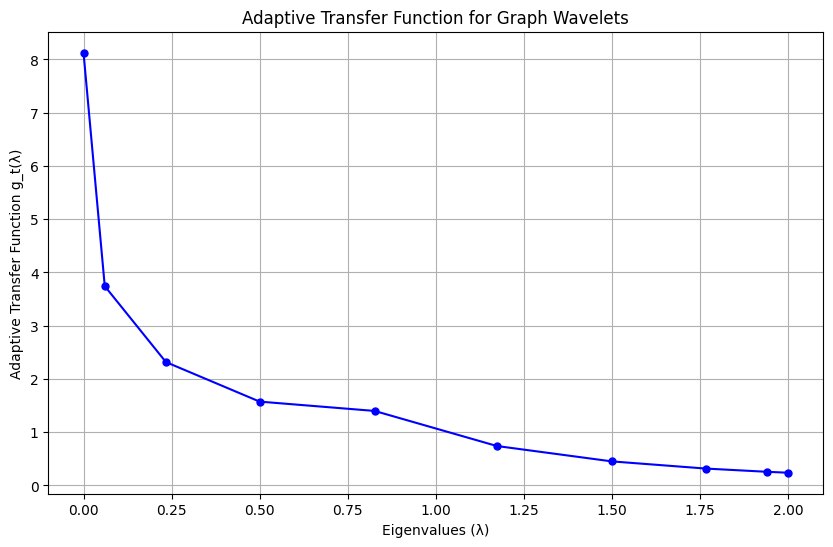

In [1]:
import numpy as np
from scipy.stats import boxcox
from scipy.linalg import eigh
import networkx as nx
import matplotlib.pyplot as plt

def adaptive_transfer_function(eigenvalues, t):
    """
    Applies the Adaptive Transfer Function to a set of eigenvalues derived from the normalized Laplacian
    of a graph. This function is tailored for use in spectral graph wavelet analysis.

    Parameters:
    ----------
    eigenvalues : array-like
        A 1D array of positive eigenvalues from the normalized Laplacian matrix of a graph.
    t : float
        The scaling parameter for the adaptive transfer function, controlling the diffusion scale.

    Returns:
    -------
    transformed_eigenvalues : numpy.ndarray
        The Box-Cox transformed eigenvalues.
    g_t : numpy.ndarray
        The adaptive transfer function values corresponding to each transformed eigenvalue.
    kappa : float
        The optimal Box-Cox transformation parameter.

    Raises:
    ------
    ValueError
        If any eigenvalue is non-positive, since Box-Cox requires positive data.
    """
    # Convert input to a NumPy array for efficient computations
    eigenvalues = np.asarray(eigenvalues)

    # Ensure all eigenvalues are positive
    if np.any(eigenvalues <= 0):
        raise ValueError("All eigenvalues must be positive for Box-Cox transformation.")

    # Apply Box-Cox transformation
    transformed_eigenvalues, kappa = boxcox(eigenvalues)

    # Compute sample mean and standard deviation of transformed eigenvalues
    mu = np.mean(transformed_eigenvalues)
    sigma = np.std(transformed_eigenvalues, ddof=1)  # Sample standard deviation

    # Compute the sum of transformed eigenvalues
    c = np.sum(transformed_eigenvalues)

    # Initialize g_t array with the same shape as transformed_eigenvalues
    g_t = np.empty_like(transformed_eigenvalues)

    # Define conditions based on the value of transformed eigenvalues
    cond1 = transformed_eigenvalues < mu
    cond2 = (transformed_eigenvalues >= mu) & (transformed_eigenvalues < mu + sigma)
    cond3 = (transformed_eigenvalues >= mu + sigma) & (transformed_eigenvalues < mu + 2 * sigma)
    cond4 = transformed_eigenvalues >= mu + 2 * sigma

    # Apply the adaptive transfer function based on the defined conditions
    g_t[cond1] = np.exp(-transformed_eigenvalues[cond1] * (1 + 2 * t / c))
    g_t[cond2] = np.exp(-transformed_eigenvalues[cond2] * (1 + 3 * t / c + sigma))
    g_t[cond3] = np.exp(-transformed_eigenvalues[cond3] * (1 + 4 * t / c + sigma))
    g_t[cond4] = np.exp(-transformed_eigenvalues[cond4] * (1 + 5 * t / c + sigma))

    return transformed_eigenvalues, g_t, kappa

def compute_normalized_laplacian(graph):
    """
    Computes the normalized Laplacian matrix of a given graph.

    Parameters:
    ----------
    graph : networkx.Graph
        The input graph.

    Returns:
    -------
    L_norm : numpy.ndarray
        The normalized Laplacian matrix.
    """
    return nx.normalized_laplacian_matrix(graph).astype(float).todense()

def get_normalized_laplacian_eigenvalues(graph):
    """
    Computes the eigenvalues of the normalized Laplacian matrix of a graph.

    Parameters:
    ----------
    graph : networkx.Graph
        The input graph.

    Returns:
    -------
    eigenvalues : numpy.ndarray
        The sorted eigenvalues of the normalized Laplacian matrix.
    """
    L_norm = compute_normalized_laplacian(graph)
    # Since the normalized Laplacian is symmetric, use eigh which is for Hermitian matrices
    eigenvalues, _ = eigh(L_norm)
    return np.array(eigenvalues).flatten()

def plot_transfer_function(eigenvalues, g_t, title="Adaptive Transfer Function"):
    """
    Plots the adaptive transfer function values against the original eigenvalues.

    Parameters:
    ----------
    eigenvalues : array-like
        Original eigenvalues from the normalized Laplacian.
    g_t : array-like
        Adaptive transfer function values.
    title : str
        Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(eigenvalues, g_t, 'bo-', markersize=5)
    plt.xlabel('Eigenvalues (λ)')
    plt.ylabel('Adaptive Transfer Function g_t(λ)')
    plt.title(title)
    plt.grid(True)
    plt.show()

# Example Usage
if __name__ == "__main__":
    # Create a sample graph (e.g., a path graph)
    G = nx.path_graph(10)

    # Compute normalized Laplacian eigenvalues
    eigenvalues = get_normalized_laplacian_eigenvalues(G)

    # Ensure all eigenvalues are positive (they are for normalized Laplacian)
    assert np.all(eigenvalues >= 0), "Normalized Laplacian eigenvalues must be non-negative."

    # Since Box-Cox requires strictly positive data, add a small constant if necessary
    # (In normalized Laplacian, eigenvalues start from 0, so we need to handle λ=0)
    # Here, we exclude the zero eigenvalue(s) or shift the spectrum
    # For demonstration, we'll shift the eigenvalues by a small epsilon
    epsilon = 1e-6
    eigenvalues_shifted = eigenvalues + epsilon

    # Scaling parameter (analogous to wavelet scaling)
    t = 0.5

    # Apply the adaptive transfer function
    transformed, g_t, kappa = adaptive_transfer_function(eigenvalues_shifted, t)

    # Display the results
    print("Original Eigenvalues:", eigenvalues)
    print("Shifted Eigenvalues:", eigenvalues_shifted)
    print("Transformed Eigenvalues:", transformed)
    print("Adaptive Transfer Function Values:", g_t)
    print("Optimal Box-Cox Parameter (kappa):", kappa)

    # Plot the adaptive transfer function
    plot_transfer_function(eigenvalues_shifted, g_t, title="Adaptive Transfer Function for Graph Wavelets")
